In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
from tqdm import tqdm
import re
import time
import argparse

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

In [3]:
!pip install mlflow --quiet
!pip install wandb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 61.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 100.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00


In [4]:
import wandb
wandb.login(key="f659082c2b19bf3ffaaceceb36c1e280541f6b11")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yeshu183 (yeshu183-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient

In [12]:
def setup_mlflow(experiment_name="handwritten-math-recognition"):
    """Set up MLflow experiment"""
    mlflow.set_experiment(experiment_name)
    return mlflow.start_run()

In [13]:
def log_params(config):
    """Log model parameters to MLflow"""
    # Log model architecture parameters
    mlflow.log_param("embed_dim", config.embed_dim)
    mlflow.log_param("hidden_dim", config.hidden_dim)
    mlflow.log_param("num_layers", config.num_layers)
    mlflow.log_param("dropout", config.dropout)
    mlflow.log_param("max_seq_len", config.max_seq_len)
    
    # Log training parameters
    mlflow.log_param("batch_size", config.batch_size)
    mlflow.log_param("num_epochs", config.num_epochs)
    mlflow.log_param("learning_rate", config.learning_rate)
    mlflow.log_param("teacher_forcing_ratio", config.teacher_forcing_ratio)
    mlflow.log_param("teacher_forcing_decay", config.teacher_forcing_decay)
    mlflow.log_param("grad_clip", config.grad_clip)
    
    # Log image preprocessing parameters
    mlflow.log_param("img_height", config.img_height)
    mlflow.log_param("img_width", config.img_width)

In [14]:
def log_metrics(metrics, step=None, prefix=""):
    """Log metrics to MLflow"""
    for metric_name, metric_value in metrics.items():
        if isinstance(metric_value, (int, float)):
            mlflow.log_metric(f"{prefix}{metric_name}", metric_value, step=step)

In [15]:
def log_model(model, tokenizer, config, artifact_name="model"):
    """Log PyTorch model to MLflow"""
    # Create a dictionary with model and necessary components
    model_info = {
        "model": model,
        "tokenizer": tokenizer,
        "config": config
    }
    
    # Define a custom loader for the saved PyTorch model
    def _load_model(model_dir):
        import torch
        import os
        model_path = os.path.join(model_dir, "model.pth")
        model_config = torch.load(os.path.join(model_dir, "model_info.pth"))
        
        # Recreate model
        model = HandwrittenMathRecognizer(model_config["config"], model_config["tokenizer"].vocab_size)
        model.load_state_dict(torch.load(model_path))
        return model, model_config["tokenizer"], model_config["config"]
    
    # Save model artifacts
    with tempfile.TemporaryDirectory() as tmp_dir:
        torch.save(model.state_dict(), os.path.join(tmp_dir, "model.pth"))
        torch.save({"tokenizer": tokenizer, "config": config}, os.path.join(tmp_dir, "model_info.pth"))
        
        mlflow.pyfunc.log_model(
            artifact_path=artifact_name,
            python_model=None,
            artifacts={"model_dir": tmp_dir},
            loader_module="mlflow.pyfunc.model"
        )

In [16]:
def log_images(image_paths, predictions, true_labels, step=None):
    """Log sample images with predictions to MLflow"""
    import matplotlib.pyplot as plt
    from PIL import Image
    import io
    
    for idx, (img_path, pred, true) in enumerate(zip(image_paths, predictions, true_labels)):
        plt.figure(figsize=(10, 6))
        plt.imshow(Image.open(img_path).convert('L'), cmap='gray')
        plt.title(f"Prediction: {pred}\nTrue: {true}")
        plt.axis('off')
        
        # Save figure to buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Log figure
        mlflow.log_figure(plt.gcf(), f"sample_{idx}_epoch_{step}.png")
        plt.close()

In [17]:
def log_artifact(file_path):
    """Log an artifact file to MLflow"""
    mlflow.log_artifact(file_path)

/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic/train/images/expr_000877.png


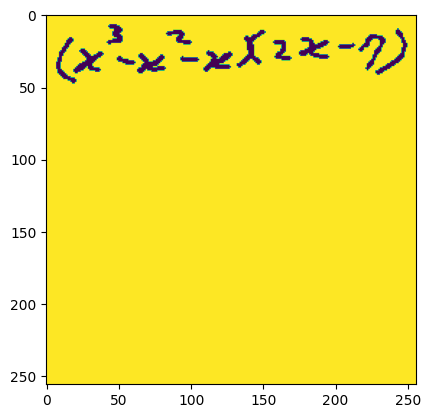

In [18]:
train_path = "/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic/train"
img_path = train_path+"/images/expr_"+"000877.png"
print(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [19]:
train_path = "/kaggle/input/crohme-data/val"
#print(os.path.join(train_path,"labels"))
count = 0
for files in os.listdir(os.path.join(train_path,"labels"))[:10]:
    #print(files)
    label_path = train_path+"/labels/"+files
    count+=1
    #print(label_path)
    f = open(label_path, 'r')
    print(f.read())
print(count)

{ 1 \mbox { u } }
$77 + 113 \geq 189$
x_x^x + y_y^y + z_z^z - x - y - z
\log \Delta
\left [ { P } _ { \mbox { I } } \right ]
{ \sigma = 6 }
$j^2 = +1$
$5 / (37 + 36 + 8) = 0.06$
$\frac{a}{\sin A} = \frac{b}{\sin B} = \frac{c}{\sin C}$
3 0 \times 2 9 x^{2 8}
10


In [20]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [21]:
# Configuration
class Config:
    def __init__(self):
        # Dataset paths
        self.data_root = '/kaggle/input/crohme-data'
        
        # Model parameters
        self.embed_dim = 256
        self.hidden_dim = 512
        self.num_layers = 1
        self.dropout = 0.3
        self.max_seq_len = 150
        
        # Training parameters
        self.batch_size = 32
        self.num_epochs = 10
        self.learning_rate = 0.001
        self.teacher_forcing_ratio = 0.9
        self.teacher_forcing_decay = 0.9
        self.grad_clip = 5.0
        
        # Tokenizer parameters
        self.special_tokens = {
            'PAD': '<PAD>',
            'START': '<START>',
            'END': '<END>',
            'UNK': '<UNK>'
        }
        
        # Image preprocessing
        self.img_height = 128
        self.img_width = 512
        
        # Checkpoint parameters
        self.checkpoint_dir = 'checkpoints'
        self.log_dir = 'logs'
        
        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Tokenizer for LaTeX expressions
class LaTeXTokenizer:
    def __init__(self, config):
        self.config = config
        self.token2idx = {}
        self.idx2token = {}
        self.build_vocab([])  # Initialize with special tokens
        
    def build_vocab(self, latex_expressions):
        # Add special tokens
        vocab = [self.config.special_tokens[token] for token in ['PAD', 'START', 'END', 'UNK']]
        
        # Add all unique tokens from latex expressions
        all_tokens = []
        for expr in latex_expressions:
            tokens = self._tokenize(expr)
            all_tokens.extend(tokens)
        
        # Count token frequencies
        token_counter = Counter(all_tokens)
        tokens = [token for token, _ in token_counter.most_common()]
        
        # Add tokens to vocabulary that aren't already special tokens
        for token in tokens:
            if token not in vocab:
                vocab.append(token)
        
        # Create mappings
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for idx, token in enumerate(vocab)}
        
        return self
    
    def _tokenize(self, latex_str):
        """
        Tokenize a LaTeX string.
        This is a simplified approach - in a production system, you might need 
        more sophisticated tokenization based on LaTeX syntax.
        """
        # Remove extra whitespace
        latex_str = latex_str.strip()
        
        # Handle special LaTeX commands
        pattern = r'(\\[a-zA-Z]+|[^a-zA-Z0-9\s])'
        
        # Split by the pattern but keep the delimiters
        parts = re.split(f'({pattern})', latex_str)
        
        # Filter out empty strings and strip whitespace
        tokens = [part.strip() for part in parts if part.strip()]
        
        return tokens
    
    def encode(self, latex_str):
        """Convert LaTeX string to token IDs"""
        tokens = self._tokenize(latex_str)
        
        # Add START and END tokens
        tokens = [self.config.special_tokens['START']] + tokens + [self.config.special_tokens['END']]
        
        # Convert to indices, using UNK for unknown tokens
        unk_idx = self.token2idx[self.config.special_tokens['UNK']]
        indices = [self.token2idx.get(token, unk_idx) for token in tokens]
        
        return indices
    
    def decode(self, indices):
        """Convert token IDs back to LaTeX string"""
        # Convert indices to tokens
        start_idx = self.token2idx[self.config.special_tokens['START']]
        end_idx = self.token2idx[self.config.special_tokens['END']]
        pad_idx = self.token2idx[self.config.special_tokens['PAD']]
        
        # Filter out special tokens
        tokens = []
        for idx in indices:
            if idx == end_idx:  # Stop at END token
                break
            if idx not in [start_idx, pad_idx]:  # Skip START and PAD tokens
                tokens.append(self.idx2token[idx])
        
        # Join tokens (with space between symbols for readability)
        latex = ' '.join(tokens)
        
        # Clean up spaces around certain symbols
        latex = re.sub(r'\s+', ' ', latex)  # Replace multiple spaces with single space
        for symbol in ['+', '-', '=', '>', '<', '\\leq', '\\geq']:
            latex = latex.replace(f' {symbol} ', f' {symbol} ')
        
        return latex.strip()
    
    @property
    def vocab_size(self):
        return len(self.token2idx)

In [23]:
# Dataset class for CROHME
class CROHMEDataset(Dataset):
    def __init__(self, data_dir, tokenizer, config, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.tokenizer = tokenizer
        self.config = config
        self.transform = transform if transform else self._get_default_transform()
        
        # Get all image paths
        split_dir = os.path.join(data_dir, split)
        self.image_paths = sorted(glob.glob(os.path.join(split_dir, 'images', '*.png')))
        
        # Load all LaTeX expressions
        self.latex_expressions = []
        for img_path in self.image_paths:
            # Get corresponding label path
            file_id = os.path.basename(img_path).split('.')[0]
            label_path = os.path.join(split_dir, 'labels', f"{file_id}.txt")
            
            if os.path.exists(label_path):
                with open(label_path, 'r', encoding='utf-8') as f:
                    latex = f.read().strip()
                self.latex_expressions.append(latex)
            else:
                print(f"Warning: Label not found for {img_path}")
                self.latex_expressions.append("")  # Empty placeholder
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load and transform image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        
        # Get and encode LaTeX
        latex = self.latex_expressions[idx]
        encoded_latex = self.tokenizer.encode(latex)
        
        # Pad sequence if needed
        if len(encoded_latex) > self.config.max_seq_len:
            encoded_latex = encoded_latex[:self.config.max_seq_len]
        else:
            pad_idx = self.tokenizer.token2idx[self.config.special_tokens['PAD']]
            encoded_latex = encoded_latex + [pad_idx] * (self.config.max_seq_len - len(encoded_latex))
        
        return {
            'image': image,
            'latex_tokens': torch.tensor(encoded_latex, dtype=torch.long),
            'latex_str': latex,
            'image_path': img_path
        }
    
    def _get_default_transform(self):
        return transforms.Compose([
            transforms.Resize((self.config.img_height, self.config.img_width)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

In [24]:
# Attention module
class AttentionModule(nn.Module):
    def __init__(self, encoder_dim, decoder_dim):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        
        # Attention layers
        self.attn = nn.Linear(encoder_dim + decoder_dim, decoder_dim)
        self.v = nn.Linear(decoder_dim, 1, bias=False)
        
    def forward(self, encoder_features, decoder_hidden):
        """
        encoder_features: (batch_size, feature_size, height, width)
        decoder_hidden: (batch_size, decoder_dim)
        """
        batch_size = encoder_features.size(0)
        
        # Reshape encoder features
        feature_size = encoder_features.size(1)
        num_pixels = encoder_features.size(2) * encoder_features.size(3)
        
        encoder_features = encoder_features.permute(0, 2, 3, 1).contiguous()
        encoder_features = encoder_features.view(batch_size, num_pixels, feature_size)
        
        # Repeat decoder hidden state
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, num_pixels, 1)
        
        # Calculate attention weights
        attention_input = torch.cat((decoder_hidden, encoder_features), dim=2)
        attention = torch.tanh(self.attn(attention_input))
        attention = self.v(attention).squeeze(2)
        
        # Apply softmax to get attention weights
        alpha = F.softmax(attention, dim=1)
        alpha = alpha.unsqueeze(2)
        
        # Apply attention weights to encoder features
        context_vector = (encoder_features * alpha).sum(dim=1)
        
        return context_vector, alpha

In [25]:
class Encoder(nn.Module):
    def __init__(self, encoded_dim):
        super().__init__()
        
        # Use ResNet18 as backbone
        resnet = models.resnet18(pretrained=True)
        
        # Remove final fully connected layer and pooling
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Adjust first conv layer to accept grayscale images
        self.resnet[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Add a projection layer to get the desired dimension
        self.projection = nn.Conv2d(512, encoded_dim, kernel_size=1)
        
    def forward(self, images):
        features = self.resnet(images)
        features = self.projection(features)
        return features

In [26]:
# Decoder - LSTM with attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, encoder_dim, num_layers=1, dropout=0.5):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.encoder_dim = encoder_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Attention module
        self.attention = AttentionModule(encoder_dim, hidden_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embed_dim + encoder_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output projection
        self.output = nn.Linear(hidden_dim, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward_step(self, encoder_features, prev_token, hidden=None):
        """Single step forward"""
        # Get embeddings
        embed = self.embedding(prev_token)  # (batch_size, 1, embed_dim)
        
        batch_size = prev_token.size(0)
        
        # Initialize hidden state if None
        if hidden is None:
            # Initialize hidden state and cell state as zeros
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
            hidden = (h_0, c_0)
        
        # Extract hidden state (ignore cell state for attention)
        hidden_state = hidden[0][-1]  # Last layer's hidden state
        
        # Rest of the method remains the same...
        # Apply attention
        context, _ = self.attention(encoder_features, hidden_state)
        context = context.unsqueeze(1)  # (batch_size, 1, encoder_dim)
        
        # Concatenate embedding and context vector
        lstm_input = torch.cat([embed, context], dim=2)
        
        # LSTM step
        output, hidden = self.lstm(lstm_input, hidden)
    
        # Project to vocabulary space
        output = self.output(self.dropout(output))
        
        return output, hidden
    
    def forward(self, encoder_features, targets=None, teacher_forcing_ratio=0.5, max_len=None):
        """
        Forward pass with optional teacher forcing
        encoder_features: (batch_size, encoder_dim, height, width)
        targets: (batch_size, max_len) - token indices
        """
        batch_size = encoder_features.size(0)
        
        # Initialize hidden state
        # Create hidden state and cell state with appropriate dimensions
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
        hidden = (h_0, c_0)
        
        # Determine sequence length
        if targets is not None:
            max_len = targets.size(1)
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, self.vocab_size).to(encoder_features.device)
        
        # First input is always <START> token
        start_idx = targets[:, 0] if targets is not None else torch.ones(batch_size).long().to(encoder_features.device)
        input_token = start_idx.unsqueeze(1)  # (batch_size, 1)
        
        # Generate sequence
        for t in range(max_len):
            # Forward step
            output, hidden = self.forward_step(encoder_features, input_token, hidden)
            
            # Store output
            outputs[:, t:t+1, :] = output
            
            # Determine next input token
            use_teacher_forcing = (random.random() < teacher_forcing_ratio) and targets is not None
            
            if use_teacher_forcing and t < max_len - 1:
                # Use ground truth as next input
                input_token = targets[:, t+1:t+2]
            else:
                # Use model's prediction as next input
                _, top_indices = output.topk(1, dim=2)
                input_token = top_indices.squeeze(2)
        
        return outputs

In [27]:
# Complete model combining encoder and decoder
class HandwrittenMathRecognizer(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.config = config
        
        # Encoder and decoder
        self.encoder = Encoder(encoded_dim=config.hidden_dim)
        self.decoder = Decoder(
            vocab_size=vocab_size,
            embed_dim=config.embed_dim,
            hidden_dim=config.hidden_dim,
            encoder_dim=config.hidden_dim,
            num_layers=config.num_layers,
            dropout=config.dropout
        )
        
    def forward(self, images, targets=None, teacher_forcing_ratio=0.5):
        # Encode images
        encoder_features = self.encoder(images)
        
        # Decode with or without teacher forcing
        outputs = self.decoder(
            encoder_features, 
            targets, 
            teacher_forcing_ratio, 
            max_len=self.config.max_seq_len if targets is None else None
        )
        
        return outputs
    
    def generate(self, images):
        """Generate LaTeX expressions without teacher forcing"""
        with torch.no_grad():
            encoder_features = self.encoder(images)
            outputs = self.decoder(
                encoder_features, 
                targets=None, 
                teacher_forcing_ratio=0.0, 
                max_len=self.config.max_seq_len
            )
            
            # Get predicted tokens
            _, predicted = outputs.max(2)
            
            return predicted

In [28]:
def clean_latex(latex_string):
    """Clean LaTeX expressions by removing unwanted duplicate symbols"""
    # List of symbols that shouldn't be repeated
    no_repeat_symbols = [
        '+', '=', '^', '-', '*', '/', '\\times', '\\div', '_', '.',
        '>', '<', '!', '\\rightarrow', '\\leftarrow', '\\Rightarrow', '\\Leftarrow',
        '\\leq', '\\geq', '\\approx', '\\sim', '\\cong', '\\neq',
        '(', ')', '[', ']', '{', '}', '|', '\\|', '\\langle', '\\rangle'
    ]
    
    # Create regex pattern for these symbols
    pattern = '|'.join([f'({re.escape(sym)}\\s*{re.escape(sym)})' for sym in no_repeat_symbols])
    
    # Replace duplicates with single occurrences
    cleaned = re.sub(pattern, lambda m: m.group(0)[0], latex_string)
    
    # Additional cleaning for spacing issues
    cleaned = re.sub(r'\s+', '', cleaned)  # Normalize spaces
    cleaned = cleaned.strip()
    
    return cleaned

In [29]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_metrics(predictions, targets, tokenizer):
    """Calculate evaluation metrics"""
    # Convert token indices to LaTeX strings
    pred_latex = [tokenizer.decode(pred.tolist()) for pred in predictions]
    target_latex = [tokenizer.decode(target.tolist()) for target in targets]
    
    # Clean LaTeX expressions
    pred_latex_clean = [clean_latex(latex) for latex in pred_latex]
    target_latex_clean = [clean_latex(latex) for latex in target_latex]
    
    # Calculate exact match accuracy with cleaned expressions
    exact_matches = sum(pred == target for pred, target in zip(pred_latex_clean, target_latex_clean))
    exact_match_accuracy = exact_matches / len(pred_latex) if len(pred_latex) > 0 else 0
    
    # Calculate token accuracy
    total_tokens = 0
    correct_tokens = 0
    
    for pred, target in zip(predictions, targets):
        # Find end index (based on END token or max sequence length)
        end_idx = tokenizer.config.max_seq_len
        for i, token in enumerate(target):
            if token.item() == tokenizer.token2idx[tokenizer.config.special_tokens['END']]:
                end_idx = i + 1
                break
        
        # Count correct tokens up to end index
        min_len = min(len(pred), end_idx)
        total_tokens += end_idx
        correct_tokens += (pred[:min_len] == target[:min_len]).sum().item()
    
    token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    
    # Calculate BLEU score
    smoother = SmoothingFunction().method1
    bleu_scores = []
    
    for pred, target in zip(pred_latex_clean, target_latex_clean):
        # Convert strings to lists of characters for character-level BLEU
        pred_chars = list(pred)
        target_chars = list(target)
        
        # Calculate BLEU score with smoothing
        try:
            score = sentence_bleu([target_chars], pred_chars, smoothing_function=smoother)
            bleu_scores.append(score)
        except:
            bleu_scores.append(0.0)
    
    # Average BLEU score
    bleu_score = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    
    # Generate 5 random indices without replacement
    total_samples = len(pred_latex)
    random_indices = np.random.choice(total_samples, size=min(5, total_samples), replace=False)
    
    return {
        'exact_match': exact_match_accuracy,
        'token_accuracy': token_accuracy,
        'bleu': bleu_score,
        'pred_examples': [pred_latex_clean[i] for i in random_indices],  # Random sample predictions
        'target_examples': [target_latex_clean[i] for i in random_indices]  # Corresponding targets
    }

In [30]:
def train_epoch(model, dataloader, criterion, optimizer, config, epoch, tokenizer):
    model.train()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    # Teacher forcing ratio with decay
    teacher_forcing_ratio = config.teacher_forcing_ratio * (config.teacher_forcing_decay ** epoch)
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} Training")
    for batch in progress_bar:
        images = batch['image'].to(config.device)
        targets = batch['latex_tokens'].to(config.device)
        
        # Forward pass
        outputs = model(images, targets, teacher_forcing_ratio)
        
        # Flatten for loss
        outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
        targets_flat = targets.contiguous().view(-1)
        
        # Compute loss (ignore_index already set in criterion)
        loss = criterion(outputs_flat, targets_flat)
        
        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        if config.grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", tf_ratio=f"{teacher_forcing_ratio:.2f}")
        
        # Store predictions and targets for metric calculation
        with torch.no_grad():
            predictions = model.generate(images)
            all_predictions.extend(predictions.detach().cpu())
            all_targets.extend(targets.detach().cpu())
    
    # Calculate train metrics
    train_metrics = calculate_metrics(all_predictions, all_targets, tokenizer)
    train_metrics['loss'] = total_loss / len(dataloader)
    
    return train_metrics

In [31]:
def evaluate(model, dataloader, criterion, tokenizer, config):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Get batch data
            images = batch['image'].to(config.device)
            targets = batch['latex_tokens'].to(config.device)
            
            # Forward pass for loss calculation
            outputs = model(images, targets, teacher_forcing_ratio=0.0)
            
            # Reshape for loss calculation
            outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
            targets_flat = targets.contiguous().view(-1)
            
            # Calculate loss
            loss = criterion(outputs_flat, targets_flat)
            total_loss += loss.item()
            
            # Generate predictions for accuracy calculation
            predictions = model.generate(images)
            
            # Store predictions and targets
            all_predictions.extend(predictions.detach().cpu())
            all_targets.extend(targets.detach().cpu())
    
    # Calculate metrics
    metrics = calculate_metrics(all_predictions, all_targets, tokenizer)
    metrics['loss'] = total_loss / len(dataloader)
    
    return metrics

In [32]:
# Create datasets
#train_dataset = CROHMEDataset('/kaggle/input/crohme-data', tokenizer, config, split='train')
#val_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='val')

In [33]:
import tempfile
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(config):
    """Main training function with metrics storage for plotting"""
    print(f"Using device: {config.device}")
    
    # Set up MLflow
    run = setup_mlflow()
    print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
    print(f"MLflow run ID: {run.info.run_id}")
    # Log parameters
    log_params(config)
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    os.makedirs(config.log_dir, exist_ok=True)
    
    # Initialize metrics storage for plotting
    metrics_history = {
        'train_loss': [],
        'train_exact_match': [],
        'train_token_accuracy': [],
        'train_bleu': [],
        'val_loss': [],
        'val_exact_match': [],
        'val_token_accuracy': [],
        'val_bleu': [],
        'epoch': []
    }
    
    # Load dataset
    print("Loading dataset...")
    
    # First, get all LaTeX expressions to build vocabulary
    all_latex = []
    for split in ['train', 'val']:
        split_dir = os.path.join(config.data_root, split)
        label_files = glob.glob(os.path.join(split_dir, 'labels', '*.txt'))
        
        for label_file in tqdm(label_files, desc=f"Reading {split} labels"):
            with open(label_file, 'r', encoding='utf-8') as f:
                all_latex.append(f.read().strip())
    
    # Create tokenizer and build vocabulary
    print("Building vocabulary...")
    tokenizer = LaTeXTokenizer(config)
    tokenizer.build_vocab(all_latex)
    print(f"Vocabulary size: {tokenizer.vocab_size}")
    
    # Create datasets
    train_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='train')
    val_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='val')

    mlflow.log_param("train_dataset_size", len(train_dataset))
    mlflow.log_param("val_dataset_size", len(val_dataset))
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        pin_memory=True,
        num_workers=2
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.batch_size, 
        shuffle=False, 
        pin_memory=True,
        num_workers=2
    )
    
    # Create model
    print("Creating model...")
    model = HandwrittenMathRecognizer(config, tokenizer.vocab_size).to(config.device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token2idx[config.special_tokens['PAD']])
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Training loop
    print(f"Starting training for {config.num_epochs} epochs...")
    best_val_loss = float('inf')
    
    for epoch in range(config.num_epochs):
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, config, epoch, tokenizer)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, tokenizer, config)
        val_loss = val_metrics['loss']
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store metrics for plotting
        metrics_history['epoch'].append(epoch + 1)
        metrics_history['train_loss'].append(train_metrics['loss'])
        metrics_history['train_exact_match'].append(train_metrics['exact_match'])
        metrics_history['train_token_accuracy'].append(train_metrics['token_accuracy']) 
        metrics_history['train_bleu'].append(train_metrics['bleu'])
        metrics_history['val_loss'].append(val_metrics['loss'])
        metrics_history['val_exact_match'].append(val_metrics['exact_match'])
        metrics_history['val_token_accuracy'].append(val_metrics['token_accuracy'])
        metrics_history['val_bleu'].append(val_metrics['bleu'])

        # Log metrics to MLflow
        log_metrics(train_metrics, step=epoch, prefix="train_")
        log_metrics(val_metrics, step=epoch, prefix="val_")
        # Log learning rate
        current_lr = optimizer.param_groups[0]['lr']
        mlflow.log_metric("learning_rate", current_lr, step=epoch)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{config.num_epochs}:")
        print(f"  Train Loss: {train_metrics['loss']:.4f}")
        print(f"  Train Exact Match: {train_metrics['exact_match']:.4f}")
        print(f"  Train Token Accuracy: {train_metrics['token_accuracy']:.4f}")
        print(f"  Train BLEU Score: {train_metrics['bleu']:.4f}")
        print(f"  Val Loss: {val_metrics['loss']:.4f}")
        print(f"  Val Exact Match: {val_metrics['exact_match']:.4f}")
        print(f"  Val Token Accuracy: {val_metrics['token_accuracy']:.4f}")
        print(f"  Val BLEU Score: {val_metrics['bleu']:.4f}")
        
        # Sample predictions
        print("Sample predictions:")
        for i in range(min(3, len(val_metrics['pred_examples']))):
            print(f"  Pred: {val_metrics['pred_examples'][i]}")
            print(f"  True: {val_metrics['target_examples'][i]}")
            print()
        
        # Save metrics history to JSON
        metrics_path = os.path.join(config.log_dir, 'metrics_history.json')
        with open(metrics_path, 'w') as f:
            json.dump(metrics_history, f, indent=4)
        
        # Save checkpoint if improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint_path = os.path.join(config.checkpoint_dir, 'best_model.pth')
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_metrics': val_metrics,
                'train_metrics': train_metrics,
                'metrics_history': metrics_history,
                'tokenizer': tokenizer,
                'config': config
            }, checkpoint_path)
            
            print(f"Saved best model checkpoint to {checkpoint_path}")
            #Logging the model 
            mlflow.pytorch.log_model(model, "best_model")
            # Log the tokenizer and config as artifacts
            with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as f:
                torch.save({'tokenizer': tokenizer, 'config': config}, f.name)
                mlflow.log_artifact(f.name, "tokenizer_config")
                os.unlink(f.name)
        # Make sure to save to Kaggle's output directory
        os.makedirs(config.checkpoint_dir, exist_ok=True)  # This is a persistent location
        # Always save latest model
        checkpoint_path = os.path.join(config.checkpoint_dir, 'latest_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_metrics': val_metrics,
            'train_metrics': train_metrics,
            'metrics_history': metrics_history,
            'tokenizer': tokenizer,
            'config': config
        }, checkpoint_path)
        os.sync()
    print("Training complete!")
    
    # Plot and save metrics graphs
    plot_metrics(metrics_history, config.log_dir)
    
    return model, tokenizer, metrics_history

In [35]:
def test_model(model, tokenizer, config, test_loader=None):
    """Test the model on the test set"""
    if test_loader is None:
        # Create test dataset and loader
        test_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='test')
        test_loader = DataLoader(
            test_dataset, 
            batch_size=config.batch_size, 
            shuffle=False,
            pin_memory=True
        )
    
    # Evaluate
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token2idx[config.special_tokens['PAD']])
    metrics = evaluate(model, test_loader, criterion, tokenizer, config)
    
    print("Test Results:")
    print(f"  Loss: {metrics['loss']:.4f}")
    print(f"  Exact Match: {metrics['exact_match']:.4f}")
    print(f"  Token Accuracy: {metrics['token_accuracy']:.4f}")
    
    # Sample predictions
    print("Sample predictions:")
    for i in range(min(5, len(metrics['pred_examples']))):
        print(f"  Pred: {metrics['pred_examples'][i]}")
        print(f"  True: {metrics['target_examples'][i]}")
        print()
    
    return metrics

In [36]:
def predict_image(model, tokenizer, image_path, config):
    """Predict LaTeX for a single image"""
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((config.img_height, config.img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(config.device)
    
    # Generate prediction
    model.eval()
    with torch.no_grad():
        prediction = model.generate(image)
        latex = tokenizer.decode(prediction[0].tolist())
    
    return clean_latex(latex)

In [37]:
def load_checkpoint(checkpoint_path, device=None):
    """Load model from checkpoint"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Get config and tokenizer
    config = checkpoint['config']
    tokenizer = checkpoint['tokenizer']
    
    # Create model
    model = HandwrittenMathRecognizer(config, tokenizer.vocab_size).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, tokenizer, config

In [39]:
def plot_metrics(metrics_history, save_dir):
    """Plot training and validation metrics and save the figures"""
    import matplotlib.pyplot as plt
    
    # Create metrics directory if it doesn't exist
    metrics_dir = os.path.join(save_dir, 'metrics_plots')
    os.makedirs(metrics_dir, exist_ok=True)
    
    # Set style
    plt.style.use('ggplot')
    
    # Create subplots for each metric
    metrics_to_plot = [
        ('loss', 'Loss'),
        ('exact_match', 'Exact Match Accuracy'),
        ('token_accuracy', 'Token Accuracy'),
        ('bleu', 'BLEU Score')
    ]
    
    for metric_key, metric_title in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        
        # Plot training and validation metrics
        train_key = f'train_{metric_key}'
        val_key = f'val_{metric_key}'
        
        plt.plot(metrics_history['epoch'], metrics_history[train_key], 'b-', label=f'Training {metric_title}')
        plt.plot(metrics_history['epoch'], metrics_history[val_key], 'r-', label=f'Validation {metric_title}')
        
        plt.xlabel('Epoch')
        plt.ylabel(metric_title)
        plt.title(f'Training and Validation {metric_title}')
        plt.legend()
        plt.grid(True)
        
        # Save figure
        save_path = os.path.join(metrics_dir, f'{metric_key}_plot.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    
    # Create a combined plot with all metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (metric_key, metric_title) in enumerate(metrics_to_plot):
        train_key = f'train_{metric_key}'
        val_key = f'val_{metric_key}'
        
        axes[i].plot(metrics_history['epoch'], metrics_history[train_key], 'b-', label=f'Training')
        axes[i].plot(metrics_history['epoch'], metrics_history[val_key], 'r-', label=f'Validation')
        
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric_title)
        axes[i].set_title(metric_title)
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    combined_save_path = os.path.join(metrics_dir, 'combined_metrics_plot.png')
    plt.savefig(combined_save_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(combined_save_path, f"metrics_plots")
    plt.show()
    plt.close()
    
    print(f"Metrics plots saved to {metrics_dir}")

In [40]:
# Instead of argparse, define these variables directly
mode = 'train'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data'
# /kaggle/input/crohme-data-basic/filtered_basic_arithmetic
checkpoint_path = None  # Path to checkpoint if needed
image_path = None  # Path to image for prediction
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# Set up configuration
config = Config()
config.data_root = data_root
config.batch_size = batch_size
config.num_epochs = num_epochs
config.learning_rate = learning_rate
config.checkpoint_dir = "/kaggle/working/"
config.log_dir = "/kaggle/working/logs"

# Set seed for reproducibility
set_seed()

2025/04/27 20:10:30 INFO mlflow.tracking.fluent: Experiment with name 'handwritten-math-recognition' does not exist. Creating a new experiment.


Using device: cuda
MLflow tracking URI: file:///kaggle/working/mlruns
MLflow run ID: 19090260b1c3461bbf9c9e868132fd63
Loading dataset...


Reading val labels: 100%|██████████| 385/385 [00:02<00:00, 132.29it/s]


Building vocabulary...
Vocabulary size: 121
Train dataset size: 757
Validation dataset size: 385
Creating model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s] 


Starting training for 50 epochs...


Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Epoch 1/50:
  Train Loss: 3.3956
  Train Exact Match: 0.0000
  Train Token Accuracy: 0.1725
  Train BLEU Score: 0.0011
  Val Loss: 3.4133
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.0717
  Val BLEU Score: 0.0000
Sample predictions:
  Pred: 
  True: p

  Pred: 
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: 
  True: z_1^2+1^z-z_2^2+2^z



2025/04/27 20:11:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:11:29 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpyjtt3ret/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:11:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.25s/it]


Epoch 2/50:
  Train Loss: 1.9150
  Train Exact Match: 0.0000
  Train Token Accuracy: 0.1651
  Train BLEU Score: 0.0032
  Val Loss: 3.5511
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.0739
  Val BLEU Score: 0.0006
Sample predictions:
  Pred: 
  True: 0

  Pred: 
  True: t

  Pred: 
  True: 33.5



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


Epoch 3/50:
  Train Loss: 1.5792
  Train Exact Match: 0.0000
  Train Token Accuracy: 0.1179
  Train BLEU Score: 0.0029
  Val Loss: 3.2358
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.1567
  Val BLEU Score: 0.0030
Sample predictions:
  Pred: 
  True: ax^4+bx+c=0

  Pred: ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  True: z_1^2+1^z-z_2^2+2^z

  Pred: 
  True: i



2025/04/27 20:12:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:12:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpu4bki3sa/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:12:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch 4/50:
  Train Loss: 1.4240
  Train Exact Match: 0.0000
  Train Token Accuracy: 0.2179
  Train BLEU Score: 0.0031
  Val Loss: 3.2372
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.1953
  Val BLEU Score: 0.0025
Sample predictions:
  Pred: 
  True: 13+\pi\pir^2

  Pred: 
  True: z

  Pred: 
  True: 5.9



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 5/50:
  Train Loss: 1.2996
  Train Exact Match: 0.0000
  Train Token Accuracy: 0.1947
  Train BLEU Score: 0.0032
  Val Loss: 3.0589
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.1817
  Val BLEU Score: 0.0030
Sample predictions:
  Pred: 
  True: 5

  Pred: ...........................................................................
  True: 36.4

  Pred: \log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log\log
  True: \log\log_2\frac\frac12+\log\log

2025/04/27 20:13:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:13:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpyy4beo50/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:13:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 6/50:
  Train Loss: 1.3416
  Train Exact Match: 0.0040
  Train Token Accuracy: 0.2249
  Train BLEU Score: 0.0116
  Val Loss: 2.7581
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.1964
  Val BLEU Score: 0.0036
Sample predictions:
  Pred: ...........................................................................
  True: 9.5

  Pred: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
  True: x^2+y^2=z^2

  Pred: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
  True: \sin\sinx-\sin\siny-\sin\sin(x-y)



2025/04/27 20:13:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:13:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpp22rjlgl/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:13:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 7/50:
  Train Loss: 1.2930
  Train Exact Match: 0.0040
  Train Token Accuracy: 0.2757
  Train BLEU Score: 0.0133
  Val Loss: 2.7517
  Val Exact Match: 0.0078
  Val Token Accuracy: 0.2889
  Val BLEU Score: 0.0165
Sample predictions:
  Pred: ......
  True: 0.8

  Pred: .....
  True: 9.5

  Pred: a++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  True: ax^4+bx+c=0



2025/04/27 20:14:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:14:28 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpj4a1k13h/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:14:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 8/50:
  Train Loss: 1.4709
  Train Exact Match: 0.0106
  Train Token Accuracy: 0.3041
  Train BLEU Score: 0.0277
  Val Loss: 2.8379
  Val Exact Match: 0.0052
  Val Token Accuracy: 0.2554
  Val BLEU Score: 0.0069
Sample predictions:
  Pred: 13
  True: \cos\cos3

  Pred: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
  True: k^3+14k^2-132k+1789

  Pred: 9..........................................................................
  True: 56.5



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 9/50:
  Train Loss: 1.2547
  Train Exact Match: 0.0119
  Train Token Accuracy: 0.3135
  Train BLEU Score: 0.0283
  Val Loss: 2.7425
  Val Exact Match: 0.0104
  Val Token Accuracy: 0.3198
  Val BLEU Score: 0.0252
Sample predictions:
  Pred: 9
  True: \pi\pi

  Pred: 9..........................................................................
  True: 0.7

  Pred: 9
  True: i



2025/04/27 20:15:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:15:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpsd0t0ivi/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:15:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 10/50:
  Train Loss: 1.2740
  Train Exact Match: 0.0119
  Train Token Accuracy: 0.3280
  Train BLEU Score: 0.0485
  Val Loss: 2.7061
  Val Exact Match: 0.0104
  Val Token Accuracy: 0.3799
  Val BLEU Score: 0.0203
Sample predictions:
  Pred: z_^^++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^
  True: z_1^2+1^z-z_2^2+2^z

  Pred: x_22^^+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  True: k^3+14k^2-132k+1789

  Pred: 5
  True: x



2025/04/27 20:15:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:15:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpaw_2cphv/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:15:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 11/50:
  Train Loss: 1.2761
  Train Exact Match: 0.0119
  Train Token Accuracy: 0.3835
  Train BLEU Score: 0.0496
  Val Loss: 2.4302
  Val Exact Match: 0.0234
  Val Token Accuracy: 0.3539
  Val BLEU Score: 0.0311
Sample predictions:
  Pred: \log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac\frac\frac2424\log\log\log__\frac
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: x_11^22+11^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^^22++^
  True: x^2+y^2=z^2

  Pred: a++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  True: a+b+c+d+e



2025/04/27 20:16:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:16:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpp5pby3jc/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:16:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 12/50:
  Train Loss: 1.3372
  Train Exact Match: 0.0119
  Train Token Accuracy: 0.4006
  Train BLEU Score: 0.0687
  Val Loss: 2.5608
  Val Exact Match: 0.0130
  Val Token Accuracy: 0.3449
  Val BLEU Score: 0.0689
Sample predictions:
  Pred: 9..
  True: 1.3

  Pred: \log\log_\frac\frac\frac24+\log\log_\frac\frac\frac2424
  True: ax^4+bx+c=0

  Pred: a+bb++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  True: a+b+c+d+e



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 13/50:
  Train Loss: 1.3886
  Train Exact Match: 0.0172
  Train Token Accuracy: 0.4451
  Train BLEU Score: 0.0822
  Val Loss: 1.7748
  Val Exact Match: 0.0104
  Val Token Accuracy: 0.5138
  Val BLEU Score: 0.1179
Sample predictions:
  Pred: 1
  True: 5

  Pred: x_x^x+y__^z-------------------------------------------------------------------
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: 9..
  True: 89.6



2025/04/27 20:17:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:17:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpq0pb_jf0/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:17:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 14/50:
  Train Loss: 1.2291
  Train Exact Match: 0.0211
  Train Token Accuracy: 0.5300
  Train BLEU Score: 0.1463
  Val Loss: 1.7970
  Val Exact Match: 0.0208
  Val Token Accuracy: 0.5372
  Val BLEU Score: 0.0971
Sample predictions:
  Pred: k^2+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  True: \sin\sin^2(x)+\cos\cos^2(x)=1

  Pred: z
  True: 4

  Pred: 13^2++^2
  True: 13+\pi\pir^2



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 15/50:
  Train Loss: 1.1090
  Train Exact Match: 0.0291
  Train Token Accuracy: 0.5742
  Train BLEU Score: 0.1864
  Val Loss: 2.1595
  Val Exact Match: 0.0104
  Val Token Accuracy: 0.5609
  Val BLEU Score: 0.1733
Sample predictions:
  Pred: x_x^x+y_y^y+y_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^z-z_y^
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: \pi
  True: 5

  Pred: x_1^2+1^2+1^2+1^2+2^2
  True: x^2+y^2=z^2



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 16/50:
  Train Loss: 0.9118
  Train Exact Match: 0.0674
  Train Token Accuracy: 0.6458
  Train BLEU Score: 0.2389
  Val Loss: 1.6997
  Val Exact Match: 0.1429
  Val Token Accuracy: 0.5754
  Val BLEU Score: 0.2285
Sample predictions:
  Pred: 6.9
  True: 6.5

  Pred: 13.9
  True: 3.57

  Pred: k^^+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
  True: k^3+14k^2-132k+1789



2025/04/27 20:18:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:18:51 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp31zspfto/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:18:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Epoch 17/50:
  Train Loss: 0.8695
  Train Exact Match: 0.0872
  Train Token Accuracy: 0.6828
  Train BLEU Score: 0.2475
  Val Loss: 1.4996
  Val Exact Match: 0.1506
  Val Token Accuracy: 0.7152
  Val BLEU Score: 0.1954
Sample predictions:
  Pred: a+b+c+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+
  True: a+b+c+d+e

  Pred: z_1^2+1^z-z_z^z-z_z^z-z-z-z-z-z-z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: a+b+c+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+d+
  True: a+b+c+d+e



2025/04/27 20:19:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:19:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpgfzrhl7n/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:19:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 18/50:
  Train Loss: 0.8325
  Train Exact Match: 0.0938
  Train Token Accuracy: 0.7028
  Train BLEU Score: 0.3056
  Val Loss: 1.2309
  Val Exact Match: 0.0494
  Val Token Accuracy: 0.6990
  Val BLEU Score: 0.2688
Sample predictions:
  Pred: 13+\pi\pirr^2
  True: 13+\pi\pir^2

  Pred: a+b+c+e
  True: a+b+c+d+e

  Pred: z_1^2+1^z-z_z^2+2^z
  True: z_1^2+1^z-z_2^2+2^z



2025/04/27 20:19:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:19:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp7vugziez/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:19:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 19/50:
  Train Loss: 0.9123
  Train Exact Match: 0.1017
  Train Token Accuracy: 0.7277
  Train BLEU Score: 0.3118
  Val Loss: 1.7129
  Val Exact Match: 0.2000
  Val Token Accuracy: 0.7195
  Val BLEU Score: 0.2684
Sample predictions:
  Pred: a+b+c+e
  True: a+b+c+d+e

  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: 1
  True: j



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 20/50:
  Train Loss: 0.7688
  Train Exact Match: 0.2153
  Train Token Accuracy: 0.7833
  Train BLEU Score: 0.3474
  Val Loss: 1.9049
  Val Exact Match: 0.1740
  Val Token Accuracy: 0.7290
  Val BLEU Score: 0.2441
Sample predictions:
  Pred: 6.5
  True: 25

  Pred: 0.3
  True: 1.3

  Pred: x_x^x+y_y^y+z_z^z-x-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-
  True: x_x^x+y_y^y+z_z^z-x-y-z



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 21/50:
  Train Loss: 0.7524
  Train Exact Match: 0.2431
  Train Token Accuracy: 0.7834
  Train BLEU Score: 0.3805
  Val Loss: 0.9431
  Val Exact Match: 0.3039
  Val Token Accuracy: 0.8138
  Val BLEU Score: 0.3998
Sample predictions:
  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: 0
  True: 41

  Pred: x^2+1^2=z^2
  True: x^2+y^2=z^2



2025/04/27 20:21:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:21:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpr2ffil6f/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:21:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Epoch 22/50:
  Train Loss: 0.7633
  Train Exact Match: 0.2880
  Train Token Accuracy: 0.8081
  Train BLEU Score: 0.4011
  Val Loss: 1.1003
  Val Exact Match: 0.2416
  Val Token Accuracy: 0.6629
  Val BLEU Score: 0.3491
Sample predictions:
  Pred: x_x^x+y_y^y+z_z^z-x-y
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: 13.
  True: \tan\tans

  Pred: a+b+c+d+e
  True: a+b+c+d+e



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 23/50:
  Train Loss: 0.6319
  Train Exact Match: 0.3712
  Train Token Accuracy: 0.8419
  Train BLEU Score: 0.4472
  Val Loss: 0.7992
  Val Exact Match: 0.4078
  Val Token Accuracy: 0.7937
  Val BLEU Score: 0.4531
Sample predictions:
  Pred: 1.3
  True: 1.3

  Pred: 9.0
  True: 5.9

  Pred: x_x^x+y_y^y+z_z^z-x-y
  True: x_x^x+y_y^y+z_z^z-x-y-z



2025/04/27 20:22:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:22:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpz8l9h8a4/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:22:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 24/50:
  Train Loss: 0.7241
  Train Exact Match: 0.3184
  Train Token Accuracy: 0.8132
  Train BLEU Score: 0.4105
  Val Loss: 1.5711
  Val Exact Match: 0.2312
  Val Token Accuracy: 0.5925
  Val BLEU Score: 0.2910
Sample predictions:
  Pred: 6.6
  True: 41.8

  Pred: 13
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: x^2+1^2
  True: z_1^2+1^z-z_2^2+2^z



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 25/50:
  Train Loss: 0.6388
  Train Exact Match: 0.3963
  Train Token Accuracy: 0.8437
  Train BLEU Score: 0.4457
  Val Loss: 0.8255
  Val Exact Match: 0.3429
  Val Token Accuracy: 0.7941
  Val BLEU Score: 0.4079
Sample predictions:
  Pred: (x^(xx-(x--))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
  True: (x^3-x^2-x)(2x-7)

  Pred: 9
  True: 9

  Pred: \sin\sin^+(x^((x--(((((((((((((()))))))))))))))))))))))))))))))))))))))))))))))))))))
  True: \sin\sinx-\sin\siny-\sin\sin(x-y)



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 26/50:
  Train Loss: 0.5539
  Train Exact Match: 0.4254
  Train Token Accuracy: 0.8528
  Train BLEU Score: 0.4572
  Val Loss: 2.0971
  Val Exact Match: 0.3091
  Val Token Accuracy: 0.7809
  Val BLEU Score: 0.3962
Sample predictions:
  Pred: 5
  True: 5

  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: x_x^x+y_y^y+z_z^z-x-y-z-z-z-z
  True: x_x^x+y_y^y+z_z^z-x-y-z



Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Epoch 27/50:
  Train Loss: 0.4766
  Train Exact Match: 0.4690
  Train Token Accuracy: 0.8653
  Train BLEU Score: 0.4756
  Val Loss: 0.5323
  Val Exact Match: 0.5247
  Val Token Accuracy: 0.8810
  Val BLEU Score: 0.5023
Sample predictions:
  Pred: 1
  True: 1

  Pred: 4
  True: b

  Pred: \tan.8
  True: 64.40



2025/04/27 20:23:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:23:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpfjk15a0i/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:23:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 28/50:
  Train Loss: 0.4401
  Train Exact Match: 0.5231
  Train Token Accuracy: 0.8932
  Train BLEU Score: 0.5054
  Val Loss: 0.4245
  Val Exact Match: 0.5377
  Val Token Accuracy: 0.9064
  Val BLEU Score: 0.5060
Sample predictions:
  Pred: k^3+14k^2-132k+1789
  True: k^3+14k^2-132k+1789

  Pred: 4
  True: 0

  Pred: 13+\pi\pir^2
  True: 13+\pi\pir^2



2025/04/27 20:24:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:24:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpsa6akczj/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:24:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 29/50:
  Train Loss: 0.3804
  Train Exact Match: 0.5495
  Train Token Accuracy: 0.8983
  Train BLEU Score: 0.5155
  Val Loss: 0.3955
  Val Exact Match: 0.5896
  Val Token Accuracy: 0.9157
  Val BLEU Score: 0.5191
Sample predictions:
  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: (x^3-x-y-x-)))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
  True: (x^3-x^2-x)(2x-7)

  Pred: 1.1
  True: 7.1



2025/04/27 20:24:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:25:05 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpb13gm124/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:25:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 30/50:
  Train Loss: 0.3625
  Train Exact Match: 0.5641
  Train Token Accuracy: 0.9077
  Train BLEU Score: 0.5255
  Val Loss: 0.3848
  Val Exact Match: 0.5455
  Val Token Accuracy: 0.9116
  Val BLEU Score: 0.5274
Sample predictions:
  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: \pi\pi
  True: \pi\pi



2025/04/27 20:25:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:25:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4i3a4cqa/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:25:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 31/50:
  Train Loss: 0.3317
  Train Exact Match: 0.5746
  Train Token Accuracy: 0.9159
  Train BLEU Score: 0.5354
  Val Loss: 0.3246
  Val Exact Match: 0.5922
  Val Token Accuracy: 0.9229
  Val BLEU Score: 0.5399
Sample predictions:
  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: 0.8
  True: 8.8

  Pred: 5
  True: 5



2025/04/27 20:26:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:26:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp1ewdk33d/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:26:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 32/50:
  Train Loss: 0.3017
  Train Exact Match: 0.5945
  Train Token Accuracy: 0.9261
  Train BLEU Score: 0.5428
  Val Loss: 0.2853
  Val Exact Match: 0.5974
  Val Token Accuracy: 0.9419
  Val BLEU Score: 0.5540
Sample predictions:
  Pred: 5.7
  True: 5.7

  Pred: 9.0
  True: 1.40

  Pred: 13+\pi\pir^2
  True: 13+\pi\pir^2



2025/04/27 20:26:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:26:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpve5_verd/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:26:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 33/50:
  Train Loss: 0.2778
  Train Exact Match: 0.5984
  Train Token Accuracy: 0.9318
  Train BLEU Score: 0.5491
  Val Loss: 0.2584
  Val Exact Match: 0.6338
  Val Token Accuracy: 0.9481
  Val BLEU Score: 0.5657
Sample predictions:
  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: j
  True: j

  Pred: 0.3
  True: 0.3



2025/04/27 20:27:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:27:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpk2otwcoq/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Epoch 34/50:
  Train Loss: 0.2555
  Train Exact Match: 0.6169
  Train Token Accuracy: 0.9426
  Train BLEU Score: 0.5611
  Val Loss: 0.2402
  Val Exact Match: 0.6416
  Val Token Accuracy: 0.9555
  Val BLEU Score: 0.5797
Sample predictions:
  Pred: k^3+14k^2-132k+1789
  True: k^3+14k^2-132k+1789

  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: 5
  True: s



2025/04/27 20:27:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:27:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp9tg99o7x/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:27:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 35/50:
  Train Loss: 0.2367
  Train Exact Match: 0.6446
  Train Token Accuracy: 0.9519
  Train BLEU Score: 0.5757
  Val Loss: 0.2163
  Val Exact Match: 0.6623
  Val Token Accuracy: 0.9650
  Val BLEU Score: 0.5896
Sample predictions:
  Pred: ax^4+bx+c=0
  True: ax^4+bx+c=0

  Pred: k^3+14k^2-132k+1789
  True: k^3+14k^2-132k+1789

  Pred: 1.7
  True: 1.7



2025/04/27 20:28:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:28:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp2xygslx4/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:28:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 36/50:
  Train Loss: 0.2204
  Train Exact Match: 0.6750
  Train Token Accuracy: 0.9575
  Train BLEU Score: 0.5799
  Val Loss: 0.1986
  Val Exact Match: 0.7065
  Val Token Accuracy: 0.9678
  Val BLEU Score: 0.6029
Sample predictions:
  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: 2
  True: c



2025/04/27 20:28:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:29:00 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpprj55owd/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:29:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 37/50:
  Train Loss: 0.1925
  Train Exact Match: 0.6816
  Train Token Accuracy: 0.9583
  Train BLEU Score: 0.5871
  Val Loss: 0.1873
  Val Exact Match: 0.7377
  Val Token Accuracy: 0.9698
  Val BLEU Score: 0.6133
Sample predictions:
  Pred: ax^4+bx+c=0
  True: ax^4+bx+c=0

  Pred: s
  True: s

  Pred: 0
  True: 0



2025/04/27 20:29:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:29:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5av6ot0z/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:29:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 38/50:
  Train Loss: 0.1885
  Train Exact Match: 0.7001
  Train Token Accuracy: 0.9647
  Train BLEU Score: 0.5938
  Val Loss: 0.1714
  Val Exact Match: 0.7195
  Val Token Accuracy: 0.9732
  Val BLEU Score: 0.6125
Sample predictions:
  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: 5
  True: 5



2025/04/27 20:29:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:30:07 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpx9wmchnb/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:30:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 39/50:
  Train Loss: 0.1703
  Train Exact Match: 0.7292
  Train Token Accuracy: 0.9653
  Train BLEU Score: 0.6007
  Val Loss: 0.1654
  Val Exact Match: 0.7610
  Val Token Accuracy: 0.9721
  Val BLEU Score: 0.6197
Sample predictions:
  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: z
  True: z

  Pred: 0
  True: 0



2025/04/27 20:30:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:30:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp25a437x4/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:30:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 40/50:
  Train Loss: 0.1581
  Train Exact Match: 0.7279
  Train Token Accuracy: 0.9711
  Train BLEU Score: 0.6060
  Val Loss: 0.1505
  Val Exact Match: 0.7429
  Val Token Accuracy: 0.9764
  Val BLEU Score: 0.6233
Sample predictions:
  Pred: b
  True: b

  Pred: e_1^2+e_2^3+e_3^4+e_4^5
  True: e_1^2+e_2^3+e_3^4+e_4^5

  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z



2025/04/27 20:31:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:31:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpsjb29vdz/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:31:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 41/50:
  Train Loss: 0.1392
  Train Exact Match: 0.7530
  Train Token Accuracy: 0.9743
  Train BLEU Score: 0.6147
  Val Loss: 0.1366
  Val Exact Match: 0.7740
  Val Token Accuracy: 0.9805
  Val BLEU Score: 0.6322
Sample predictions:
  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: \sin\sin\sin
  True: \sin\sin5

  Pred: 2.4
  True: 2.4



2025/04/27 20:31:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:31:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp9et_2ddv/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:31:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


Epoch 42/50:
  Train Loss: 0.1319
  Train Exact Match: 0.7860
  Train Token Accuracy: 0.9798
  Train BLEU Score: 0.6234
  Val Loss: 0.1244
  Val Exact Match: 0.8052
  Val Token Accuracy: 0.9849
  Val BLEU Score: 0.6420
Sample predictions:
  Pred: 2
  True: 2

  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z



2025/04/27 20:32:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:32:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpebw8cwv4/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:32:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 43/50:
  Train Loss: 0.1202
  Train Exact Match: 0.7966
  Train Token Accuracy: 0.9812
  Train BLEU Score: 0.6286
  Val Loss: 0.1137
  Val Exact Match: 0.8468
  Val Token Accuracy: 0.9879
  Val BLEU Score: 0.6491
Sample predictions:
  Pred: e_1^2+e_2^3+e_3^4+e_4^5
  True: e_1^2+e_2^3+e_3^4+e_4^5

  Pred: \pi\pi
  True: \pi\pi

  Pred: 5.7
  True: 5.7



2025/04/27 20:32:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:32:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp2lc_ybza/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:32:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 44/50:
  Train Loss: 0.1047
  Train Exact Match: 0.8349
  Train Token Accuracy: 0.9863
  Train BLEU Score: 0.6394
  Val Loss: 0.1048
  Val Exact Match: 0.8701
  Val Token Accuracy: 0.9905
  Val BLEU Score: 0.6551
Sample predictions:
  Pred: t
  True: t

  Pred: 9.3
  True: 31.3

  Pred: j
  True: 11



2025/04/27 20:33:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:33:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpx70oye8x/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:33:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 45/50:
  Train Loss: 0.1004
  Train Exact Match: 0.8388
  Train Token Accuracy: 0.9878
  Train BLEU Score: 0.6423
  Val Loss: 0.1001
  Val Exact Match: 0.8883
  Val Token Accuracy: 0.9918
  Val BLEU Score: 0.6606
Sample predictions:
  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: o
  True: o

  Pred: 0
  True: 0



2025/04/27 20:33:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:34:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpjbfczjzn/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:34:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 46/50:
  Train Loss: 0.0958
  Train Exact Match: 0.8375
  Train Token Accuracy: 0.9856
  Train BLEU Score: 0.6369
  Val Loss: 0.0962
  Val Exact Match: 0.8468
  Val Token Accuracy: 0.9886
  Val BLEU Score: 0.6507
Sample predictions:
  Pred: p
  True: p

  Pred: ax^4+bx+c=0
  True: ax^4+bx+c=0

  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24



2025/04/27 20:34:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:34:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp_ubtdvwk/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:34:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 47/50:
  Train Loss: 0.0877
  Train Exact Match: 0.8454
  Train Token Accuracy: 0.9878
  Train BLEU Score: 0.6446
  Val Loss: 0.0898
  Val Exact Match: 0.8883
  Val Token Accuracy: 0.9918
  Val BLEU Score: 0.6664
Sample predictions:
  Pred: m
  True: n

  Pred: ax^4+bx+c=0
  True: ax^4+bx+c=0

  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z



2025/04/27 20:35:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:35:11 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp6ybb3o0s/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:35:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 48/50:
  Train Loss: 0.0808
  Train Exact Match: 0.8851
  Train Token Accuracy: 0.9913
  Train BLEU Score: 0.6557
  Val Loss: 0.0820
  Val Exact Match: 0.8805
  Val Token Accuracy: 0.9914
  Val BLEU Score: 0.6586
Sample predictions:
  Pred: (y+1)^2=y^2+2y+1
  True: (y+1)^2=y^2+2y+1

  Pred: 7.5
  True: 7.5

  Pred: 7
  True: 77



2025/04/27 20:35:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:35:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpl018dqia/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:35:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 49/50:
  Train Loss: 0.0739
  Train Exact Match: 0.8943
  Train Token Accuracy: 0.9915
  Train BLEU Score: 0.6570
  Val Loss: 0.0744
  Val Exact Match: 0.9273
  Val Token Accuracy: 0.9948
  Val BLEU Score: 0.6776
Sample predictions:
  Pred: a
  True: a

  Pred: 3.1
  True: 3.1

  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z



2025/04/27 20:36:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:36:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp57xyqsqd/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:36:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Epoch 50/50:
  Train Loss: 0.0707
  Train Exact Match: 0.9009
  Train Token Accuracy: 0.9920
  Train BLEU Score: 0.6573
  Val Loss: 0.0712
  Val Exact Match: 0.9299
  Val Token Accuracy: 0.9950
  Val BLEU Score: 0.6818
Sample predictions:
  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: 13+\pi\pir^2
  True: 13+\pi\pir^2

  Pred: q
  True: q



2025/04/27 20:36:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 20:36:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpa90t1kz_/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/04/27 20:36:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training complete!


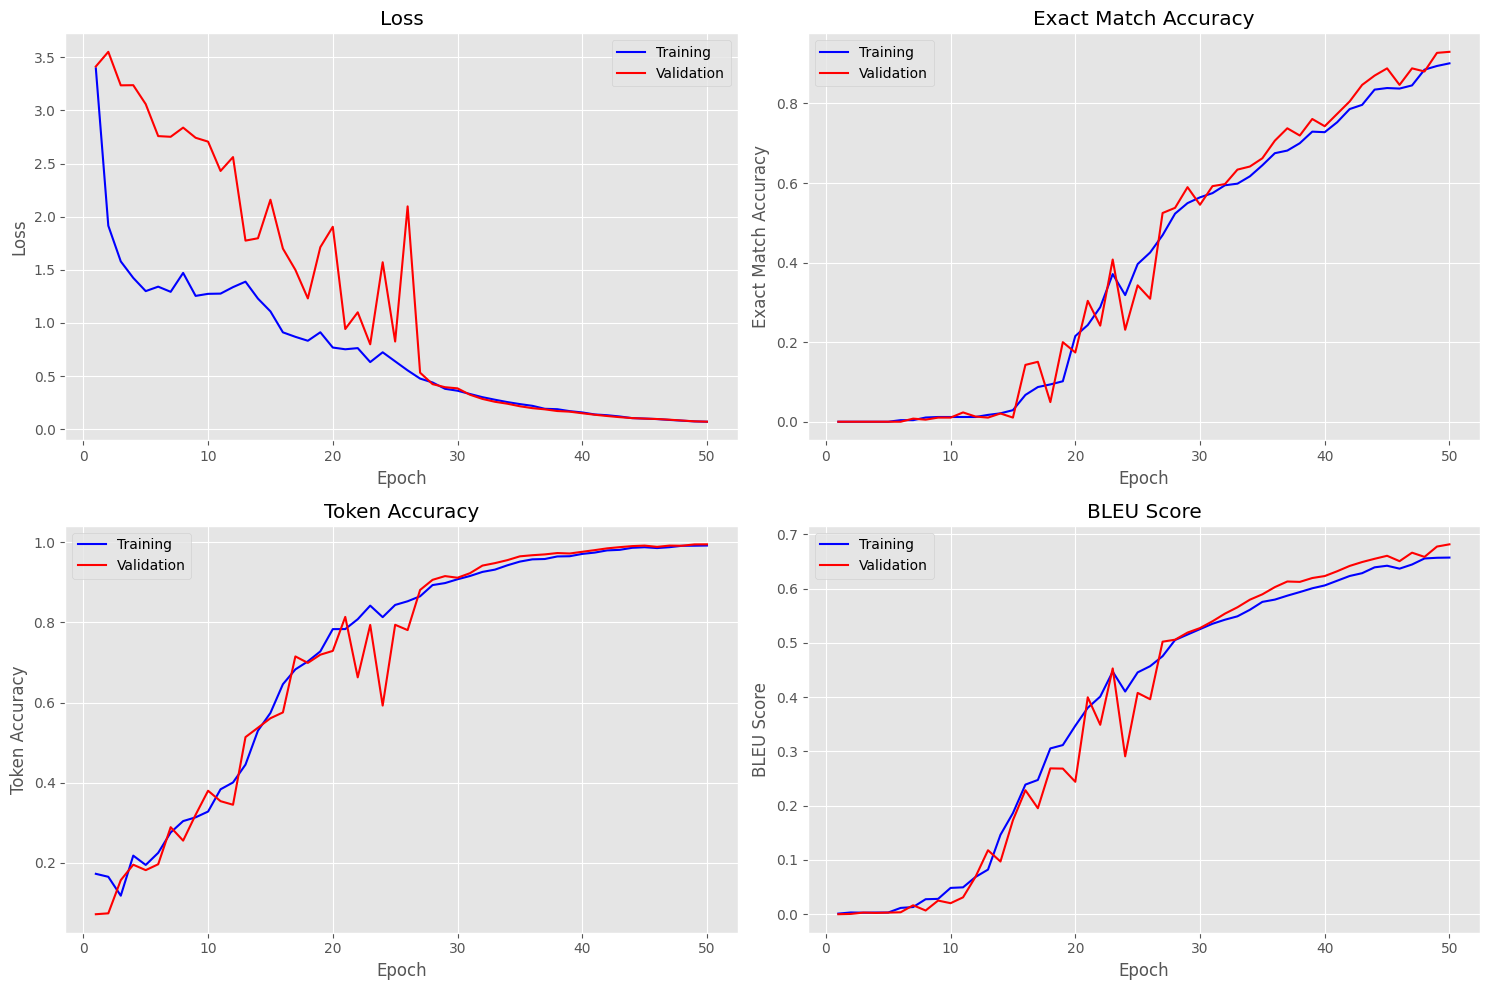

Metrics plots saved to /kaggle/working/logs/metrics_plots


In [41]:
mlflow.end_run()
# Training mode
if mode == 'train':
    if checkpoint_path:
        # Continue training from checkpoint
        print(f"Loading checkpoint from {checkpoint_path}...")
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            if key not in ['batch_size', 'num_epochs', 'learning_rate']:
                setattr(config, key, value)
        
        model, tokenizer, metrics_history = train_model(config)
    else:
        # Train from scratch
        model, tokenizer,metrics_history = train_model(config)

In [ ]:
def register_model_to_mlflow(model_path, model_name, tags=None):
    """Register a model in the MLflow model registry"""
    # Load the saved model
    loaded_model, tokenizer, config = load_checkpoint(model_path)
    
    # Start a new run for model registration
    with mlflow.start_run(run_name=f"register_{model_name}"):
        # Log model parameters
        log_params(config)
        
        # Log the model
        mlflow.pytorch.log_model(loaded_model, "model")
        
        # Register the model in the model registry
        registered_model = mlflow.register_model(
            f"runs:/{mlflow.active_run().info.run_id}/model",
            model_name
        )
        
        # Add tags if provided
        if tags:
            client = MlflowClient()
            for key, value in tags.items():
                client.set_model_version_tag(
                    name=model_name,
                    version=registered_model.version,
                    key=key,
                    value=value
                )
        
        print(f"Model registered with name: {model_name}, version: {registered_model.version}")
        
        # Log additional artifacts
        with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as f:
            torch.save({'tokenizer': tokenizer, 'config': config}, f.name)
            mlflow.log_artifact(f.name, "tokenizer_config")
            os.unlink(f.name)
    
    return registered_model

In [ ]:
def load_model_from_registry(model_name, version=None, stage=None):
    """Load a model from the MLflow model registry"""
    client = MlflowClient()
    
    # Get the model version URI
    if version is not None:
        model_uri = f"models:/{model_name}/{version}"
    elif stage is not None:
        model_uri = f"models:/{model_name}/{stage}"
    else:
        model_uri = f"models:/{model_name}/latest"
    
    # Load the PyTorch model
    loaded_model = mlflow.pytorch.load_model(model_uri)
    
    # Get the run ID for this model version
    if version is not None:
        model_version = client.get_model_version(model_name, version)
    else:
        # Get latest version
        versions = client.search_model_versions(f"name='{model_name}'")
        latest_version = max(versions, key=lambda x: int(x.version))
        model_version = latest_version
    
    run_id = model_version.run_id
    
    # Download the tokenizer and config
    artifacts_path = client.download_artifacts(run_id, "tokenizer_config")
    tokenizer_config = torch.load(os.path.join(artifacts_path, os.listdir(artifacts_path)[0]))
    
    return loaded_model, tokenizer_config['tokenizer'], tokenizer_config['config']

In [ ]:
mlflow.end_run()
mode = 'test'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic'
checkpoint_path = "checkpoints/best_model.pth"
# Testing mode
if mode == 'test':
    if not checkpoint_path:
        print("Error: Checkpoint path is required for testing")
    else:
        # Load model from checkpoint
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            setattr(config, key, value)
        
        # Test model
        metrics = test_model(model, tokenizer, config)
        # Register the model in MLflow model registry
        register_model_to_mlflow(
            checkpoint_path, 
            "handwritten-math-recognition", 
            tags={
                "accuracy": f"{metrics['exact_match']:.4f}",
                "dataset": os.path.basename(config.data_root),
                "description": "Handwritten mathematical expression recognition model"
            }
        )

In [ ]:
save_dir = "/kaggle/working"
plot_metrics(metrics_history, save_dir)

In [ ]:
import sys
mode = 'predict'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data'
checkpoint_path = "checkpoints/best_model.pth"
image_path = "/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic/test/images/expr_000865.png"
# Prediction mode
if mode == 'predict':
    if not checkpoint_path or not image_path:
        print("Error: Both checkpoint and image paths are required for prediction")
    else:
        # Load model from checkpoint
        #model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)

        # Try to load from model registry
        try:
            model, tokenizer, loaded_config = load_model_from_registry("handwritten-math-recognition")
            print(f"Loaded model handwritten-math-recognition from MLflow model registry")
        except Exception as e:
            print(f"Error loading model from registry: {e}")
            sys.exit(1)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            setattr(config, key, value)
        filename = os.path.basename(image_path)
        match = re.search(r'expr_(\d+)\.png', filename)
        id = match.group(1)
        image_dir = os.path.dirname(image_path)
        parent_dir = os.path.dirname(image_dir)
        label_path = os.path.join(parent_dir, 'labels', f'expr_{id}.txt')
        f = open(label_path,'r')
        true_latex = f.read()
        
        # Predict on image
        latex = predict_image(model, tokenizer, image_path, config)
        print(f"Predicted LaTeX: {latex}")
        print(f"True LaTeX: {true_latex}")
        
        # Optional: Display the image
        from PIL import Image
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 4))
        plt.imshow(Image.open(image_path).convert('L'), cmap='gray')
        #plt.title(f"Prediction: {latex}")
        plt.axis('off')
        plt.show()

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()

# For older MLflow versions
try:
    # Try to get registered models using search_registered_models (newer versions)
    registered_models = client.search_registered_models()
    for rm in registered_models:
        print(f"Model: {rm.name}")
        
        # List versions for this model
        versions = client.get_latest_versions(rm.name)
        for v in versions:
            print(f"  Version: {v.version}, Stage: {v.current_stage}, Run ID: {v.run_id}")
except AttributeError:
    # Fallback for very old versions - list all runs and extract model info
    print("Using fallback method to list models:")
    runs = mlflow.search_runs()
    if not runs.empty:
        print(f"Found {len(runs)} runs")
        for _, run in runs.iterrows():
            print(f"Run ID: {run.run_id}, Experiment ID: {run.experiment_id}")
            # Try to get artifacts list
            try:
                artifacts = client.list_artifacts(run.run_id)
                for artifact in artifacts:
                    if artifact.path.startswith("model"):
                        print(f"  Model artifact: {artifact.path}")
            except:
                print("  Could not list artifacts for this run")
    else:
        print("No runs found")